In [1]:
from larcv import larcv
import numpy
import datetime

base_path = '/Users/deltutto/nextnew_files/data_larcv/'


# file_name = '/Users/deltutto/Downloads/run6828_fulldataset.h5' # OLD
# file_name = '/Users/deltutto/Downloads/run6828_full_dataset_cor_dv.h5' # NEW

file_name_data = {}
file_name_data[6818] = base_path + 'run6818_full_dataset_cor_dv_larcv.h5'
file_name_data[6822] = base_path + 'run6822_full_dataset_cor_dv_larcv.h5'
file_name_data[6823] = base_path + 'run6823_full_dataset_cor_dv_larcv.h5'
file_name_data[6826] = base_path + 'run6826_full_dataset_cor_dv_larcv.h5'
file_name_data[6828] = base_path + 'run6828_full_dataset_cor_dv_larcv.h5'

In [2]:
event_energy = {}
total_events = {}
for run, file_name in file_name_data.items():
    print ('-> Run =', run)
    io = larcv.IOManager()
    io.add_in_file(file_name_data[run])
    io.initialize()
    
    total_events[run] = io.get_n_entries()
    event_energy[run] = []
    
    for i in range(io.get_n_entries()):
        io.read_entry(i)
    
        image3d = larcv.EventSparseTensor3D.to_sparse_tensor(io.get_data("sparse3d", "voxels_E"))
        energy = image3d.as_vector().front().sum()
        
        event_energy[run].append(energy)
        
        if i % 1000 == 0:
            print ('At event', i, float(i)/io.get_n_entries(), '%')

('-> Run =', 6818)
('At event', 0, 0.0, '%')
('At event', 1000, 0.2246686137946529, '%')
('At event', 2000, 0.4493372275893058, '%')
('At event', 3000, 0.6740058413839587, '%')
('At event', 4000, 0.8986744551786116, '%')
('-> Run =', 6828)
('At event', 0, 0.0, '%')
('At event', 1000, 0.27502750275027504, '%')
('At event', 2000, 0.5500550055005501, '%')
('At event', 3000, 0.8250825082508251, '%')
('-> Run =', 6826)
('At event', 0, 0.0, '%')
('At event', 1000, 0.23952095808383234, '%')
('At event', 2000, 0.47904191616766467, '%')
('At event', 3000, 0.718562874251497, '%')
('At event', 4000, 0.9580838323353293, '%')
('-> Run =', 6822)
('At event', 0, 0.0, '%')
('At event', 1000, 0.10434056761268781, '%')
('At event', 2000, 0.20868113522537562, '%')
('At event', 3000, 0.31302170283806346, '%')
('At event', 4000, 0.41736227045075125, '%')
('At event', 5000, 0.5217028380634391, '%')
('At event', 6000, 0.6260434056761269, '%')
('At event', 7000, 0.7303839732888147, '%')
('At event', 8000, 0.8

In [3]:
import pandas
import glob
import os
import argparse
import numpy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from random import random

In [4]:
import textwrap

def measurement_string(x, u_x):
    """
    Display a value-uncertainty pair with the same precision.
    """
    scale = int(np.floor(np.log10(u_x)))
    if scale >= 2:
        return "({}) · 1e{}".format(measurement_string(  x/10**scale,
                                                       u_x/10**scale),
                                    scale)
    n = 1 - scale

    format = "{" + ":.{}f".format(n) + "}"
    string = "{} +- {}".format(format, format)

    return string.format(np.round(  x, n),
                         np.round(u_x, n))

In [5]:
from scipy.optimize import curve_fit

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def get_errors(cov):
    """
    Find errors from covariance matrix
    Parameters
    ----------
    cov : np.ndarray
        Covariance matrix of the fit parameters.
    Returns
    -------
    err : 1-dim np.ndarray
        Errors asociated to the fit parameters.
    """
    return np.sqrt(np.diag(cov))

def fit(func, x, y, seed=(), fit_range=None, **kwargs):
    if fit_range is not None:
        sel = (fit_range[0] <= x) & (x < fit_range[1])
        x, y = x[sel], y[sel]
        
    vals, cov = curve_fit(func, x, y, seed, **kwargs)
    
    fitf = lambda x: func(x, *vals)
    
    return fitf, vals, get_errors(cov)

('Total number of events:', 0.19363779778830781)


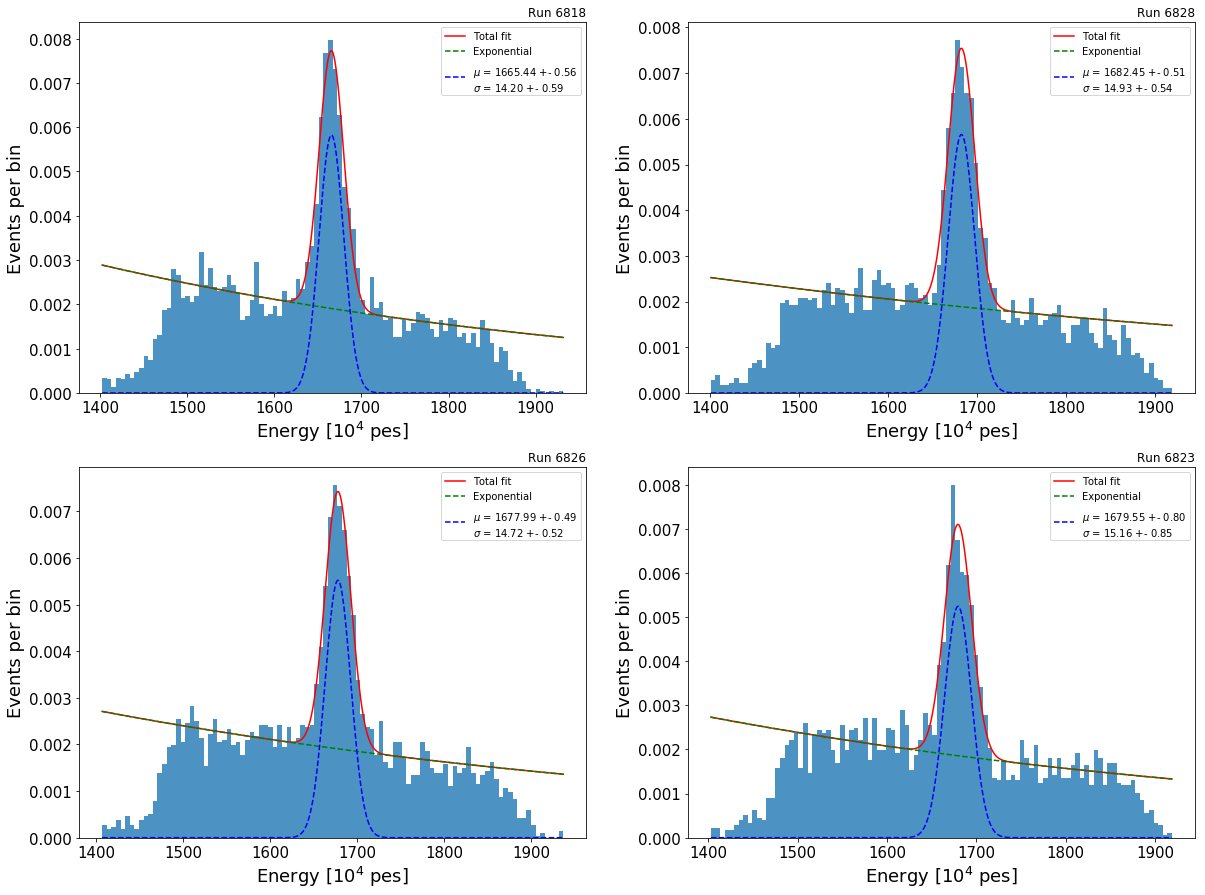

{6818: 9.5590231032729078e-05, 6828: 9.4623958447306687e-05, 6826: 9.4875158027207018e-05, 6823: 9.4787037792200371e-05}


In [6]:
fig=plt.figure(figsize=(20,15),facecolor='w')

peak_energy = 1592
scale_factors = {}

scale = 1

n_plot = 1

for run, energies in event_energy.items():
    
    if run == 6822:
        continue
#     if run != 6818:
#         continue

    ax = plt.subplot(2, 2, n_plot)
    n_plot += 1
    
    energies = np.array(energies)
    energies = energies/1e4
    energies = energies[energies > 1400]
    n, bins, patches = plt.hist(energies, bins=100, normed=1, alpha=0.8, weights=len(energies)*[scale])
    
    binscenters = numpy.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    seed = 15, -445, 15000, 1700, 11
    fitf, vals, errs = fit(func=expgauss, x=binscenters, y=n, seed=seed, fit_range=(1500, 1800))
    
    xmin = min(bins)
    xmax = max(bins)
    xf = np.linspace(xmin, xmax, 1000)

    legend = textwrap.dedent("""$\mu$ = {0}\n$\sigma$ = {1}""".format(measurement_string(vals[3] , errs[3]),
                        measurement_string(vals[4] , errs[4])))

    
    plt.plot(xf, fitf(xf), 'r-', label='Total fit')
    plt.plot(xf, exp(xf, vals[0], vals[1]), 'g--', label='Exponential')
    plt.plot(xf, gauss(xf, vals[2], vals[3], vals[4]), 'b--', label=legend)
    
    ax.set_title('Run ' + str(run), loc='right')
    
    plt.legend()
    plt.ylabel('Events per bin',fontsize=18)
    plt.xlabel('Energy [$10^{4}$ pes]',fontsize=18)
    plt.tick_params(labelsize=15)
    
    scale_factors[run] = peak_energy / (vals[3] * 1e4)


print ('Total number of events:', np.sum(n))
plt.savefig('data_raw_tote_fitted.pdf')
plt.show()
print scale_factors

('Fitted. Run = ', 6818, 'Total events =', 4600.00443866579, 'Background events =', 3639.717262970086, 'Signal events =', 960.287175695704)
('Fitted. Run = ', 6828, 'Total events =', 3925.6099782839815, 'Background events =', 3125.1751784156813, 'Signal events =', 800.4347998682998)
('Fitted. Run = ', 6826, 'Total events =', 4459.052149382541, 'Background events =', 3584.940739480246, 'Signal events =', 874.1114099022955)
('Fitted. Run = ', 6823, 'Total events =', 3677.5291754485706, 'Background events =', 2976.6233410719683, 'Signal events =', 700.9058343766023)
('Total number of events:', 0.23868365932977792)


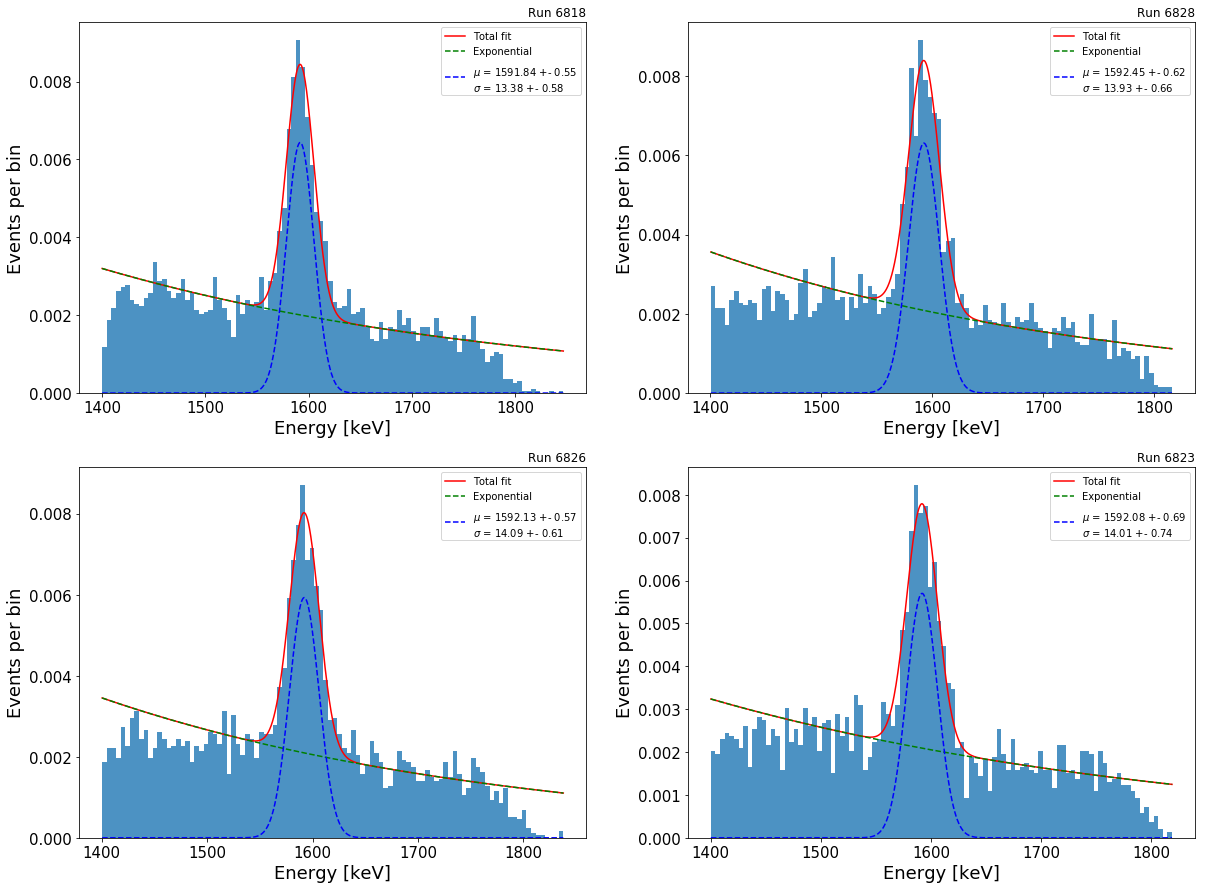

In [7]:
fig=plt.figure(figsize=(20,15),facecolor='w')

scale = 1
n_plot = 1

for run, energies in event_energy.items():
    
    if run == 6822:
        continue
#     if run != 6818:
#         continue

    ax = plt.subplot(2, 2, n_plot)
    n_plot += 1
    
    energies = np.array(energies)
    energies = energies * scale_factors[run]
    energies = energies[energies > 1400]
    n, bins, patches = plt.hist(energies, bins=100, normed=1, alpha=0.8, weights=len(energies)*[scale])
    
    binscenters = numpy.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    seed = 15, -445, 15000, 1600, 11
    fitf, vals, errs = fit(func=expgauss, x=binscenters, y=n, seed=seed, fit_range=(1500, 1800))
    
    xmin = min(bins)
    xmax = max(bins)
    xf = np.linspace(xmin, xmax, 1000)

    legend = textwrap.dedent("""$\mu$ = {0}\n$\sigma$ = {1}""".format(measurement_string(vals[3] , errs[3]),
                        measurement_string(vals[4] , errs[4])))

    
    plt.plot(xf, fitf(xf), 'r-', label='Total fit')
    plt.plot(xf, exp(xf, vals[0], vals[1]), 'g--', label='Exponential')
    plt.plot(xf, gauss(xf, vals[2], vals[3], vals[4]), 'b--', label=legend)
    
    ax.set_title('Run ' + str(run), loc='right')
    
    plt.legend()
    plt.ylabel('Events per bin',fontsize=18)
    plt.xlabel('Energy [keV]',fontsize=18)
    plt.tick_params(labelsize=15)
    
    from scipy.integrate import quad
    I_expgauss = quad(expgauss, 1400, 1800, args=(vals[0], vals[1], vals[2], vals[3], vals[4]))
    I_exp = quad(exp, 1400, 1800, args=(vals[0], vals[1]))
    I_gauss = quad(gauss, 1400, 1800, args=(vals[2], vals[3], vals[4]))
    print ('Fitted. Run = ', run,
            'Total events =', I_expgauss[0] * total_events[run], 
            'Background events =', I_exp[0] * total_events[run], 
            'Signal events =', I_gauss[0] * total_events[run])


print ('Total number of events:', np.sum(n))
plt.savefig('data_raw_tote_fitted_scaled.pdf')
plt.show()